## Setup
First we import all the required modules

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

## Visualization
First we choose the dataset blood-fat.csv and import the data:

In [120]:
bloodfatdata = pd.read_csv("./datasets/blood-fat.csv")

bloodfatdata

,Weight,Age,Blood fat
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451
5,69,25,302
6,63,28,288
7,72,36,385
8,79,57,402
9,75,44,365


Now we can summarize the data by evaluating the statistics

In [121]:
bloodfatdata.describe()

,Weight,Age,Blood fat
count,25.000000,25.000000,25.00000
mean,68.680000,39.120000,310.72000
std,12.727005,12.248537,77.82915
min,27.000000,20.000000,181.00000
25%,63.000000,30.000000,254.00000
50%,69.000000,37.000000,303.00000
75%,76.000000,50.000000,374.00000
max,89.000000,60.000000,451.00000


Now we can visualize the data by creating a pairplot with pairwise feature scatterplots and feature histograms:

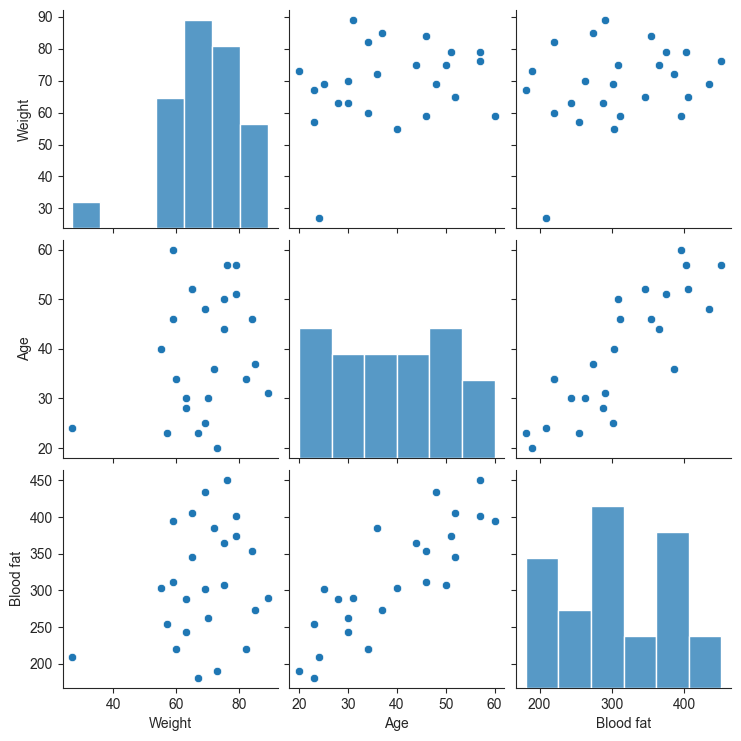

In [122]:
sns.set_style('ticks')
sns.pairplot(data=bloodfatdata)

Now we can also create a heatmap out of the feature correlation matrix

<Axes: >

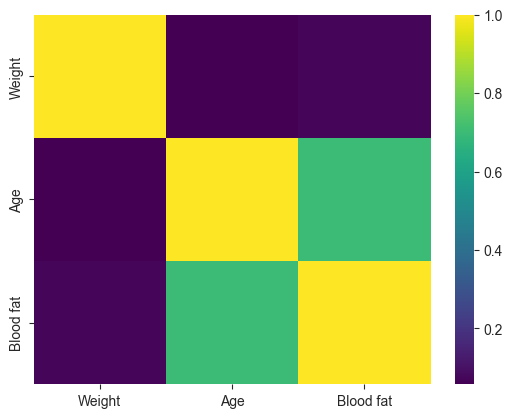

In [123]:
correlation_matrix = bloodfatdata.corr(numeric_only=True)
correlation_matrix
sns.heatmap(correlation_matrix ** 2, cmap='viridis')

## Linear Regression
Now we can perform linear regression on the data. As we can see blood fat and age have the best correlation so we try to perform lienar regression on these 2 features:

In [124]:
bloodfatdata.corr() ** 2

,Weight,Age,Blood fat
Weight,1.000000,0.057606,0.070381
Age,0.057606,1.000000,0.701161
Blood fat,0.070381,0.701161,1.000000


Now we can perform linear regression on the 2 features:

beta vector:  [array([5.32067632]), 102.57514219694275]


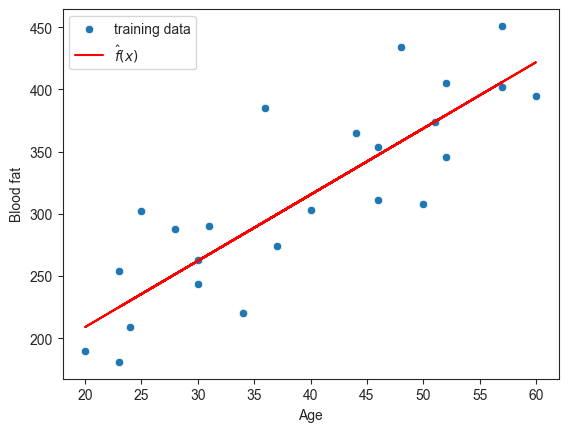

In [125]:
fig, ax = plt.subplots()
sns.scatterplot(data=bloodfatdata, x='Age', y='Blood fat', label='training data')

x = bloodfatdata['Age'].values.reshape(-1, 1) # we have to call reshape because it's a single feature and sklearn expects a matrix
y = bloodfatdata['Blood fat'].values
lr = LinearRegression()
lr.fit(x, y)
print("beta vector: ", [lr.coef_, lr.intercept_])

y_pred = lr.predict(x)
ax.plot(x, y_pred, color='red', label='$\hat{f}(x)$')
ax.legend()

Now we can also evaluate the Prediction qualitiy:

In [126]:
print('Prediction quality: ', r2_score(y, y_pred))

Prediction quality:  0.7011606902368127


## Polynomial Regression
Now we can also try to use Polynomial Regression:

polynomial degree 1: train score: 0.7957491333850097, test score: 0.39176292182523176
polynomial degree 2: train score: 0.7986315318591066, test score: 0.3909420872445314
polynomial degree 3: train score: 0.8334596775334119, test score: 0.20107193940356305
polynomial degree 4: train score: 0.8685943700695046, test score: -0.21965991206050672


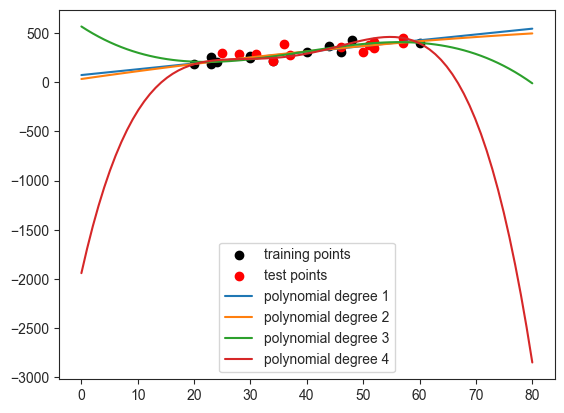

In [278]:
train_split = 0.5

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bloodfatdata['Age'].values.reshape(-1, 1),
    bloodfatdata['Blood fat'].values,
    train_size=train_split, 
    test_size=1-train_split,
    shuffle=True,
    random_state=6
)

# Sort the training data based on Age
sorted_indices = np.argsort(X_train.flatten())
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

fig, ax = plt.subplots()

# plot Training and test data
ax.scatter(X_train, y_train, label='training points', color='black')
ax.scatter(X_test, y_test, label='test points', color='red')

for degree in range(1, 5):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_sorted, y_train_sorted)

    # Generate a range of values for plotting
    x_values = np.linspace(0, 80, 80).reshape(-1, 1)

    # Predictions on the combined data
    y_values_pred = model.predict(x_values)

    ax.plot(x_values, y_values_pred, label=f'polynomial degree {degree}')
    ax.legend()

    y_train_pred = model.predict(X_train_sorted)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train_sorted, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'polynomial degree {degree}: train score: {r2_train}, test score: {r2_test}')

plt.show()

### Conclusion
If we increase the degree of the polynomial, the train score gets better, however the testscore gets worse. Using Linear Regression provides the best score.

## Elastic Net
Now we can also try to use Polynomial Regression:

polynomial degree 1: train score: 0.7957491333838758, test score: 0.3917633152579937
polynomial degree 2: train score: 0.7986315318043018, test score: 0.3909429382000529
polynomial degree 3: train score: 0.812070717935303, test score: 0.35837062530322283
polynomial degree 4: train score: 0.8313486042135939, test score: 0.2778798140381814
polynomial degree 5: train score: 0.8401258501580465, test score: 0.18430171719871757


c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+03, tolerance: 7.445e+00
  model = cd_fast.enet_coordinate_descent(
c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.278e+03, tolerance: 7.445e+00
  model = cd_fast.enet_coordinate_descent(
c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

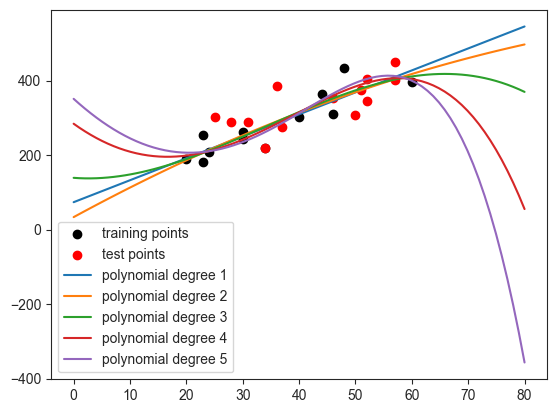

In [280]:
train_split = 0.5

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bloodfatdata['Age'].values.reshape(-1, 1),
    bloodfatdata['Blood fat'].values,
    train_size=train_split, 
    test_size=1-train_split,
    shuffle=True,
    random_state=6
)

# Sort the training data based on Age
sorted_indices = np.argsort(X_train.flatten())
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

fig, ax = plt.subplots()

# plot Training and test data
ax.scatter(X_train, y_train, label='training points', color='black')
ax.scatter(X_test, y_test, label='test points', color='red')

for degree in range(1, 6):
    model = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=1e-3, l1_ratio=1))
    model.fit(X_train_sorted, y_train_sorted)

    # Generate a range of values for plotting
    x_values = np.linspace(0, 80, 80).reshape(-1, 1)

    # Predictions on the combined data
    y_values_pred = model.predict(x_values)

    ax.plot(x_values, y_values_pred, label=f'polynomial degree {degree}')
    ax.legend()

    y_train_pred = model.predict(X_train_sorted)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train_sorted, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'polynomial degree {degree}: train score: {r2_train}, test score: {r2_test}')

plt.show()

### Conclusion
When using ElasticNet, the R1-Score is basically the same when compared to using LinearRegression, for a polynomial degree of 1. However the test score gets better for increased polynomial scores, indicating that the generalization capabilities of the model are improved.